### Instalación de dependencias

In [1]:
!pip install emnist

     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB 1.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/78.3 kB ? eta -:--:--
   ---------------------------------------- 78.3/78.3 kB ? eta 0:00:00


# Dataset 1: MNIST

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
import numpy as np

# Cargar el conjunto de datos MNIST
mnist = fetch_openml('mnist_784')

# Barajar los datos
mnist.data, mnist.target = shuffle(mnist.data, mnist.target, random_state=42)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_mnist, X_test_mnist, y_train_mnist, y_test_mnist = train_test_split(mnist.data, mnist.target, test_size=0.10, random_state=42)

# Normalización de los datos
scaler = StandardScaler()
X_train_mnist = scaler.fit_transform(X_train_mnist)
X_test_mnist = scaler.transform(X_test_mnist)


In [5]:
X_train_mnist.shape

(63000, 784)

In [6]:
U_mnist, S_mnist, VT_mnist = np.linalg.svd(X_train_mnist, full_matrices=False)

11


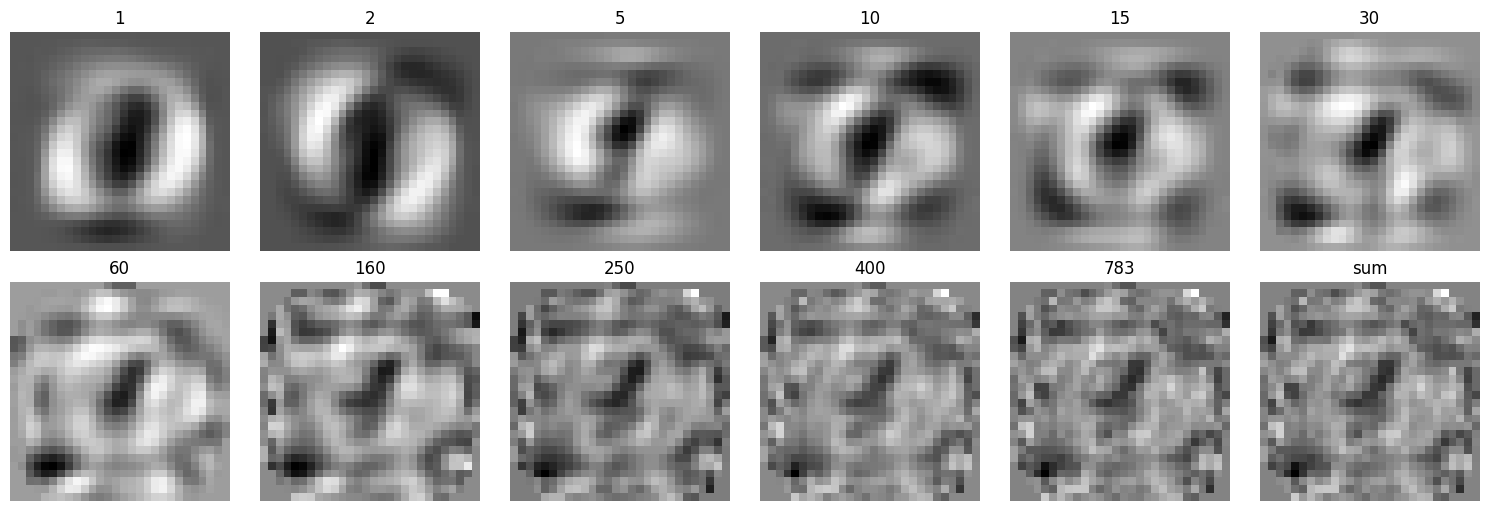

In [35]:
import matplotlib.pyplot as plt

sample=10
nrows, ncols = 2,6
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15*nrows/ncols), constrained_layout=True)

dims = [1, 2, 5, 10, 15, 30] + [60, 160, 250, 400, 783]

def reconstruir(dim,c):
  ax = axes.flat[c]
  ax.set_axis_off()
  ax.imshow(np.sum(VT_mnist.T[:, :dim] * S_mnist[:dim], axis=1).reshape(28,28), cmap=plt.cm.gray, interpolation="none")
  ax.set_title(f"{dim}")

ax = axes.flat[-1]
ax.set_axis_off()
ax.imshow(np.sum(VT_mnist.T * S_mnist, axis=1).reshape(28,28), cmap=plt.cm.gray, interpolation="none")
ax.set_title(f"sum")

print(len(dims))
for i,d in enumerate(dims):
  reconstruir(d,i)


11


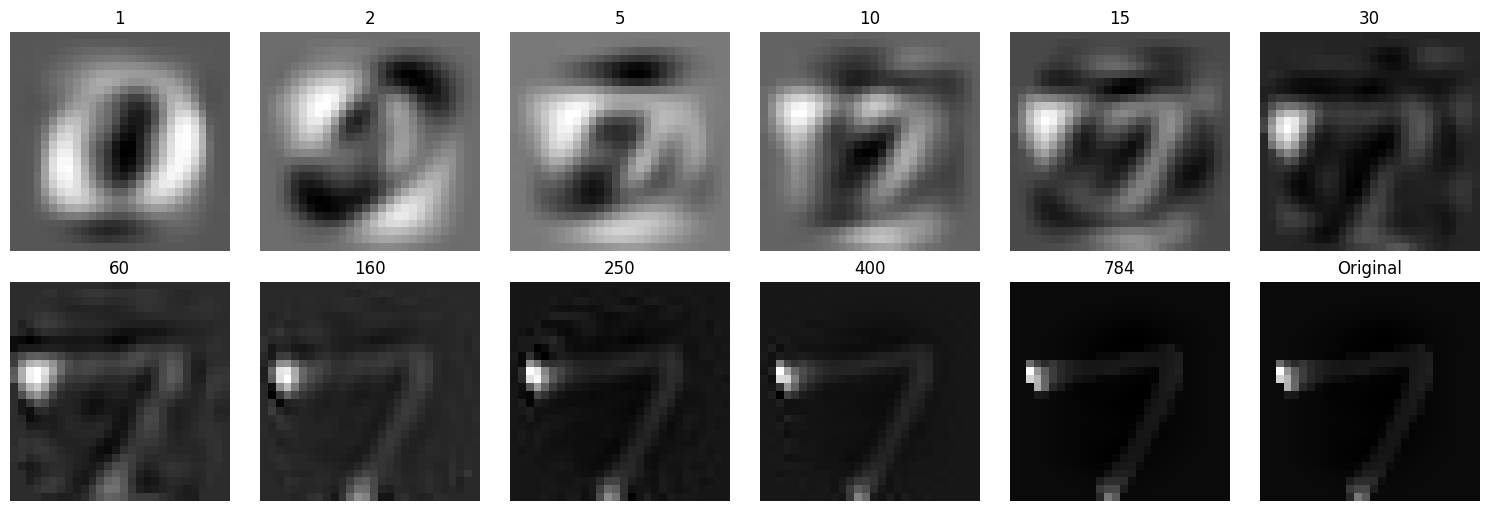

In [11]:
import matplotlib.pyplot as plt

sample=10
nrows, ncols = 2,6
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15*nrows/ncols), constrained_layout=True)

dims = [1, 2, 5, 10, 15, 30] + [60, 160, 250, 400, 784]

def reconstruir(dim,c):
  reduced_X = X_train_mnist[sample,:] @ VT_mnist.T[:, :dim]
  X_reconstructed = reduced_X @ VT_mnist[:dim, :]
  ax = axes.flat[c]
  ax.set_axis_off()
  ax.imshow(X_reconstructed.reshape(28,28), cmap=plt.cm.gray, interpolation="none")
  ax.set_title(f"{dim}")

  ax = axes.flat[-1]
  ax.set_axis_off()
  ax.imshow(X_train_mnist[sample,:].reshape(28,28), cmap=plt.cm.gray, interpolation="none")
  ax.set_title(f"Original")
  
print(len(dims))
for i,d in enumerate(dims):
  reconstruir(d,i)


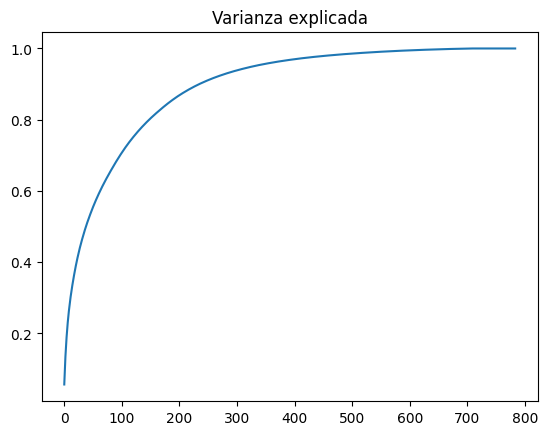

In [36]:
import matplotlib.pyplot as plt

plt.plot(np.cumsum(S_mnist**2)/np.sum(S_mnist**2))
plt.title("Varianza explicada")
plt.show()

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

accs_mnist_lr = []
red_dims =  [1, 5, 10, 20, 30, 50, 75, 100, 150, 200, 300, 400, 500, 700]
classifiers_mnist_lr = []
for dim in red_dims:
  reduced_X_train = X_train_mnist @ VT_mnist.T[:, :dim]
  reduced_X_test = X_test_mnist @ VT_mnist.T[:, :dim]
  clf = LogisticRegression(max_iter=1000).fit(reduced_X_train, y_train_mnist)
  classifiers_mnist_lr.append(clf)
  acc = accuracy_score(y_test_mnist, clf.predict(reduced_X_test))
  accs_mnist_lr.append(acc)
  print(f'La precisión para la dimensión {dim} es {acc:<1.3}')



La precisión para la dimensión 1 es 0.306
La precisión para la dimensión 5 es 0.684
La precisión para la dimensión 10 es 0.801
La precisión para la dimensión 20 es 0.862
La precisión para la dimensión 30 es 0.885
La precisión para la dimensión 50 es 0.898
La precisión para la dimensión 75 es 0.908
La precisión para la dimensión 100 es 0.913
La precisión para la dimensión 150 es 0.919
La precisión para la dimensión 200 es 0.921
La precisión para la dimensión 300 es 0.922
La precisión para la dimensión 400 es 0.92
La precisión para la dimensión 500 es 0.918
La precisión para la dimensión 700 es 0.914


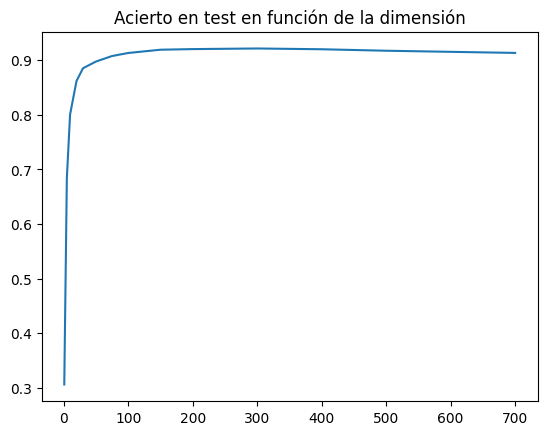

[0.3057142857142857, 0.684, 0.8007142857142857, 0.8621428571428571, 0.8854285714285715, 0.8977142857142857, 0.9078571428571428, 0.9134285714285715, 0.9194285714285715, 0.9205714285714286, 0.9217142857142857, 0.9202857142857143, 0.9175714285714286, 0.9135714285714286]


In [38]:
import matplotlib.pyplot as plt

plt.plot(red_dims, accs_mnist_lr)
plt.title("Acierto en test en función de la dimensión")
plt.show()
print(accs_mnist_lr)

In [51]:
i = np.argmax(accs_mnist_lr)
print(accs_mnist_lr[i], red_dims[i])

0.9217142857142857 300


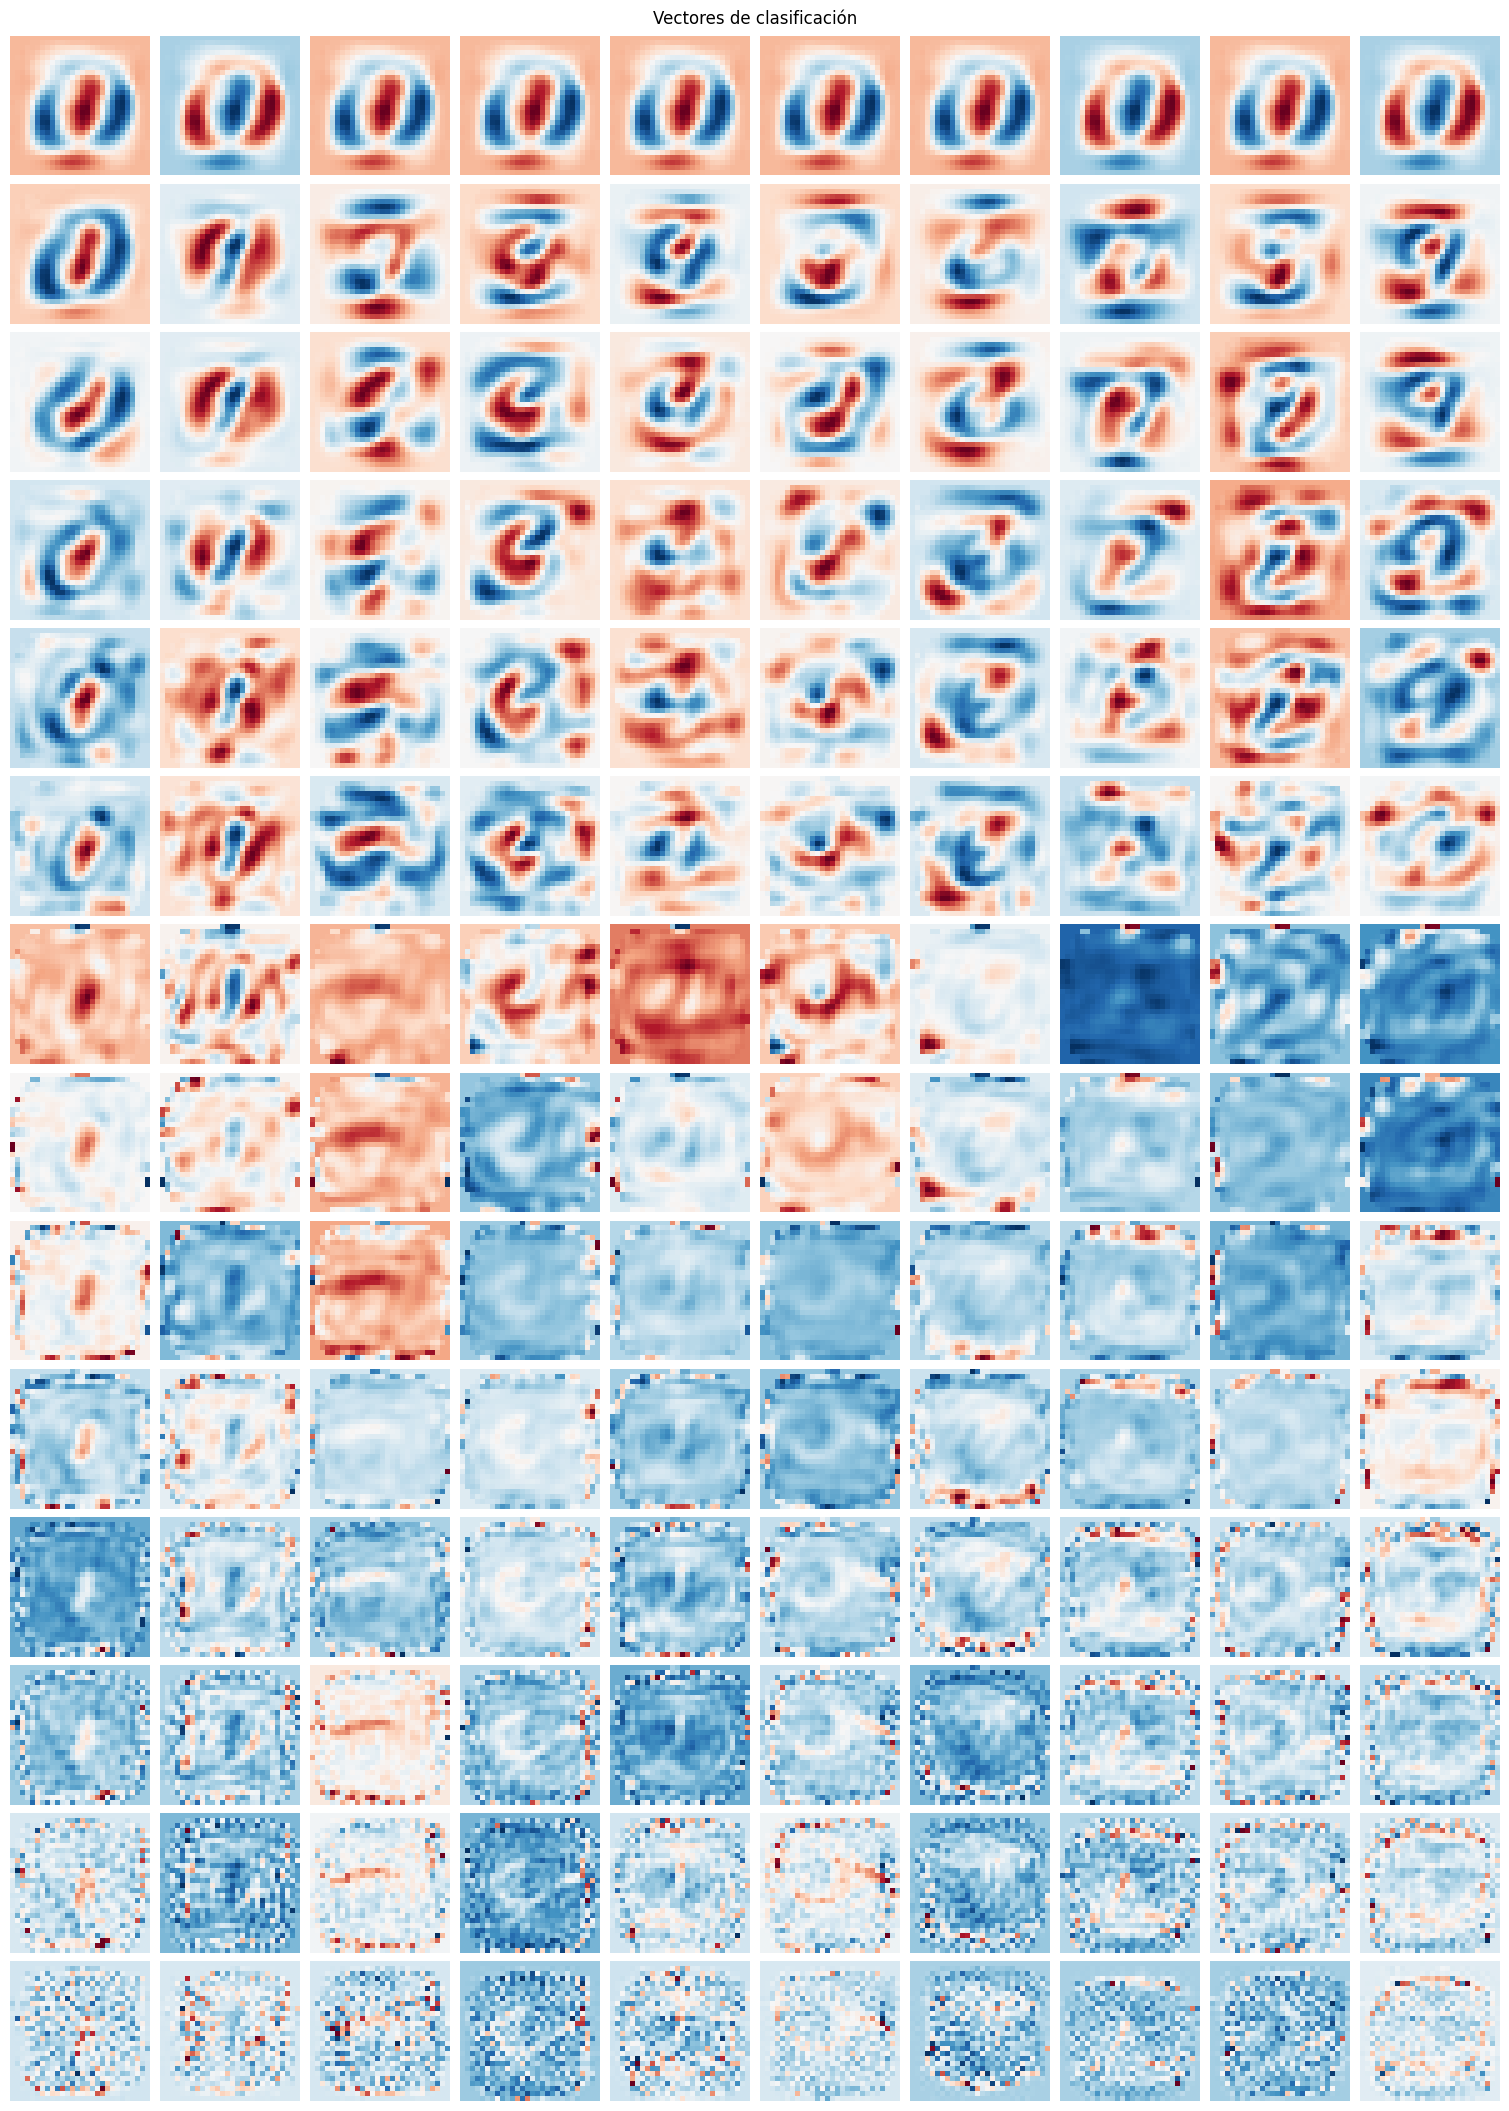

In [47]:
import matplotlib.pyplot as plt

coefs = [clf.coef_.copy() for clf in classifiers_mnist_lr]
nrows, ncols = len(coefs),coefs[0].shape[0]
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15*nrows/ncols), constrained_layout=True)

for i,coef in enumerate(coefs):
  scale = np.abs(coef).max()
  for sel_class in range(coef.shape[0]):
    coef_reconstructed = coef[sel_class] @ VT_mnist[:red_dims[i], :]
    ax = axes[i][sel_class]
    ax.set_axis_off()
    ax.imshow(
        coef_reconstructed.reshape(28, 28),
        interpolation="nearest",
        cmap=plt.cm.RdBu,

    )
plt.suptitle("Vectores de clasificación")
plt.show()

In [48]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
import numpy as np

accs_mnist_per = []

red_dims =  [1, 5, 10, 20, 30, 50, 75, 100, 150, 200, 300, 400, 500, 700]
classifiers_mnist_per = []
for dim in red_dims:
  reduced_X_train = X_train_mnist @ VT_mnist.T[:, :dim]
  reduced_X_test = X_test_mnist @ VT_mnist.T[:, :dim]
  clf = Perceptron().fit(reduced_X_train, y_train_mnist)
  classifiers_mnist_per.append(clf)

  acc = accuracy_score(y_test_mnist, clf.predict(reduced_X_test))
  accs_mnist_per.append(acc)
  print(f'La precisión para la dimensión {dim} es {acc:<1.3}')

La precisión para la dimensión 1 es 0.13
La precisión para la dimensión 5 es 0.474
La precisión para la dimensión 10 es 0.631
La precisión para la dimensión 20 es 0.776
La precisión para la dimensión 30 es 0.802
La precisión para la dimensión 50 es 0.842
La precisión para la dimensión 75 es 0.853
La precisión para la dimensión 100 es 0.861
La precisión para la dimensión 150 es 0.868
La precisión para la dimensión 200 es 0.874
La precisión para la dimensión 300 es 0.888
La precisión para la dimensión 400 es 0.872
La precisión para la dimensión 500 es 0.88
La precisión para la dimensión 700 es 0.875


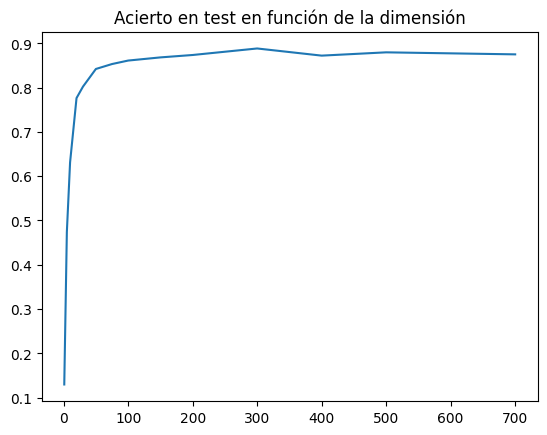

[0.12971428571428573, 0.47385714285714287, 0.6311428571428571, 0.7764285714285715, 0.8022857142857143, 0.8421428571428572, 0.8532857142857143, 0.8611428571428571, 0.8682857142857143, 0.8737142857142857, 0.8884285714285715, 0.8722857142857143, 0.8797142857142857, 0.8751428571428571]


In [49]:
import matplotlib.pyplot as plt

plt.plot(red_dims, accs_mnist_per)
plt.title("Acierto en test en función de la dimensión")
plt.show()
print(accs_mnist_per)

In [53]:
i = np.argmax(accs_mnist_per)
print(accs_mnist_per[i], red_dims[i])

0.8884285714285715 300


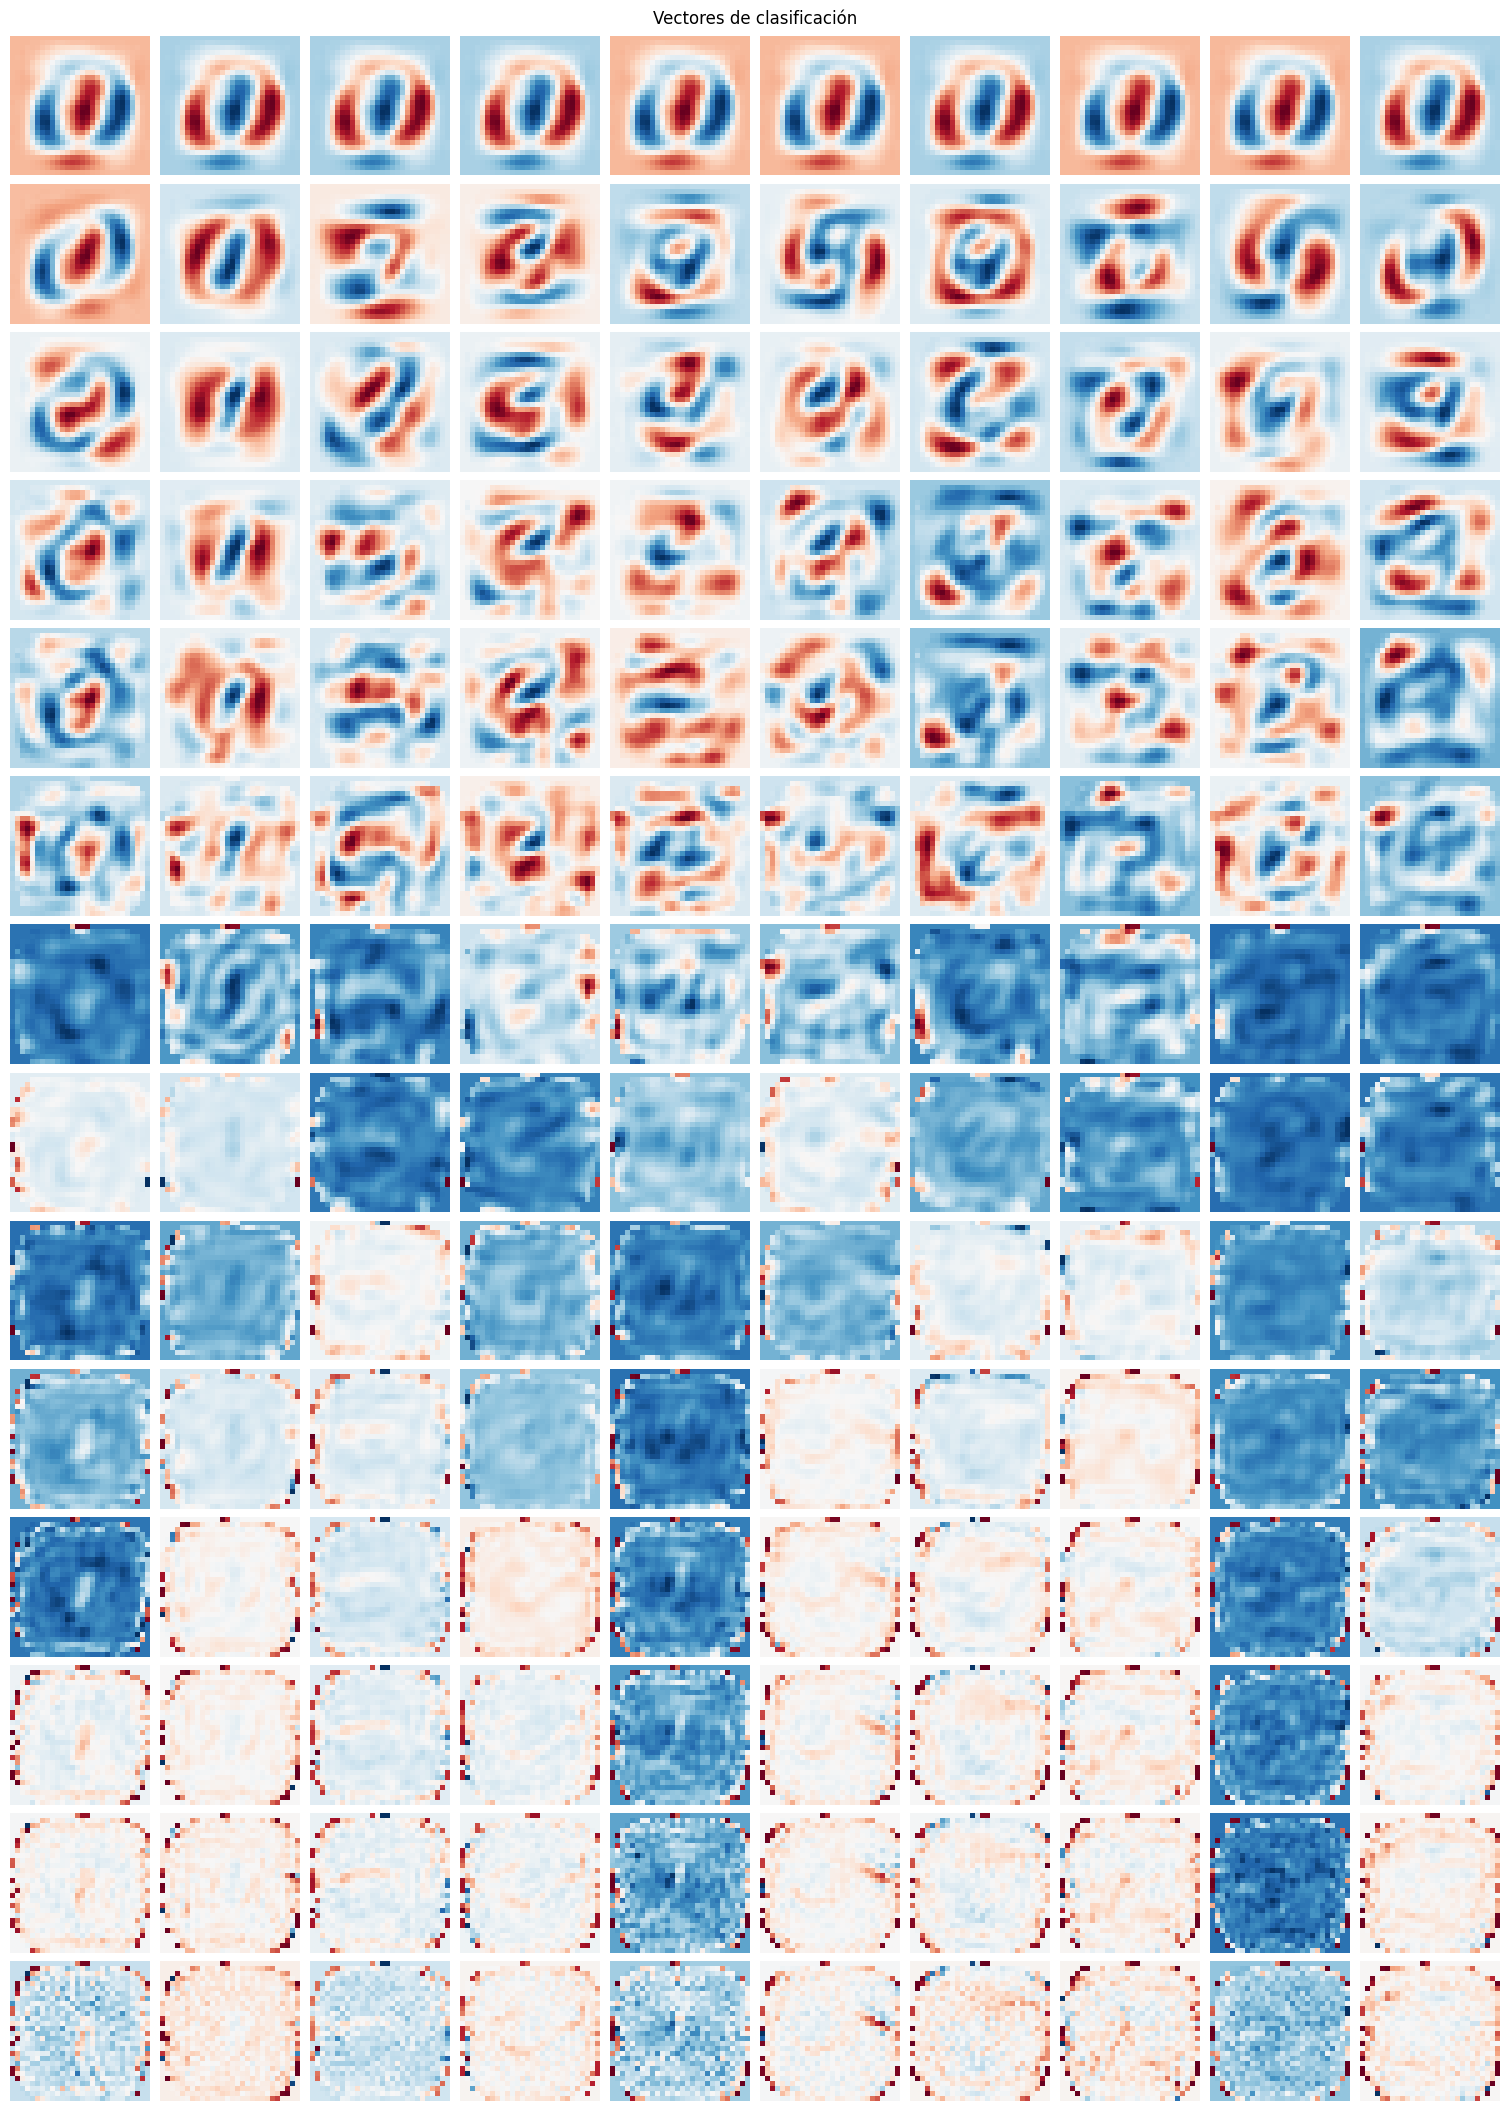

In [54]:
import matplotlib.pyplot as plt

coefs = [clf.coef_.copy() for clf in classifiers_mnist_per]
nrows, ncols = len(coefs),coefs[0].shape[0]
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15*nrows/ncols), constrained_layout=True)

for i,coef in enumerate(coefs):
  scale = np.abs(coef).max()
  for sel_class in range(coef.shape[0]):
    coef_reconstructed = coef[sel_class] @ VT_mnist[:red_dims[i], :]
    ax = axes[i][sel_class]
    ax.set_axis_off()
    ax.imshow(
        coef_reconstructed.reshape(28, 28),
        interpolation="nearest",
        cmap=plt.cm.RdBu,

    )
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_xlabel("Class %i" % sel_class)
plt.suptitle("Vectores de clasificación")
plt.show()

# Dataset 2: EMNIST

### Lectura de los datos

In [55]:
from emnist import extract_training_samples, extract_test_samples
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

X_train_em, y_train_em = extract_training_samples('letters')  # Conjunto de entrenamiento
X_test_em, y_test_em = extract_test_samples('letters')  # Conjunto de prueba
X_train_em = X_train_em.reshape((X_train_em.shape[0],28*28))
X_test_em = X_test_em.reshape((X_test_em.shape[0],28*28))

X_train_em, y_train_em = shuffle(X_train_em, y_train_em, random_state=42)

reduction_train = X_train_em.shape[0] // 2

X_train_em = X_train_em[:reduction_train]
y_train_em = y_train_em[:reduction_train]

# Normalización de los datos
scaler = StandardScaler()
X_train_em = scaler.fit_transform(X_train_em)
X_test_em = scaler.transform(X_test_em)


In [ ]:
X_train_em.shape
X_test_em.shape

(62400, 784)

### Descomposición en Valores Signulares (SVD)

In [56]:
U_em, S_em, VT_em = np.linalg.svd(X_train_em, full_matrices=False)

### Visualización de la reconstrucción de la muestra nº53 en función de las dimensiones a las que se la ha reducido

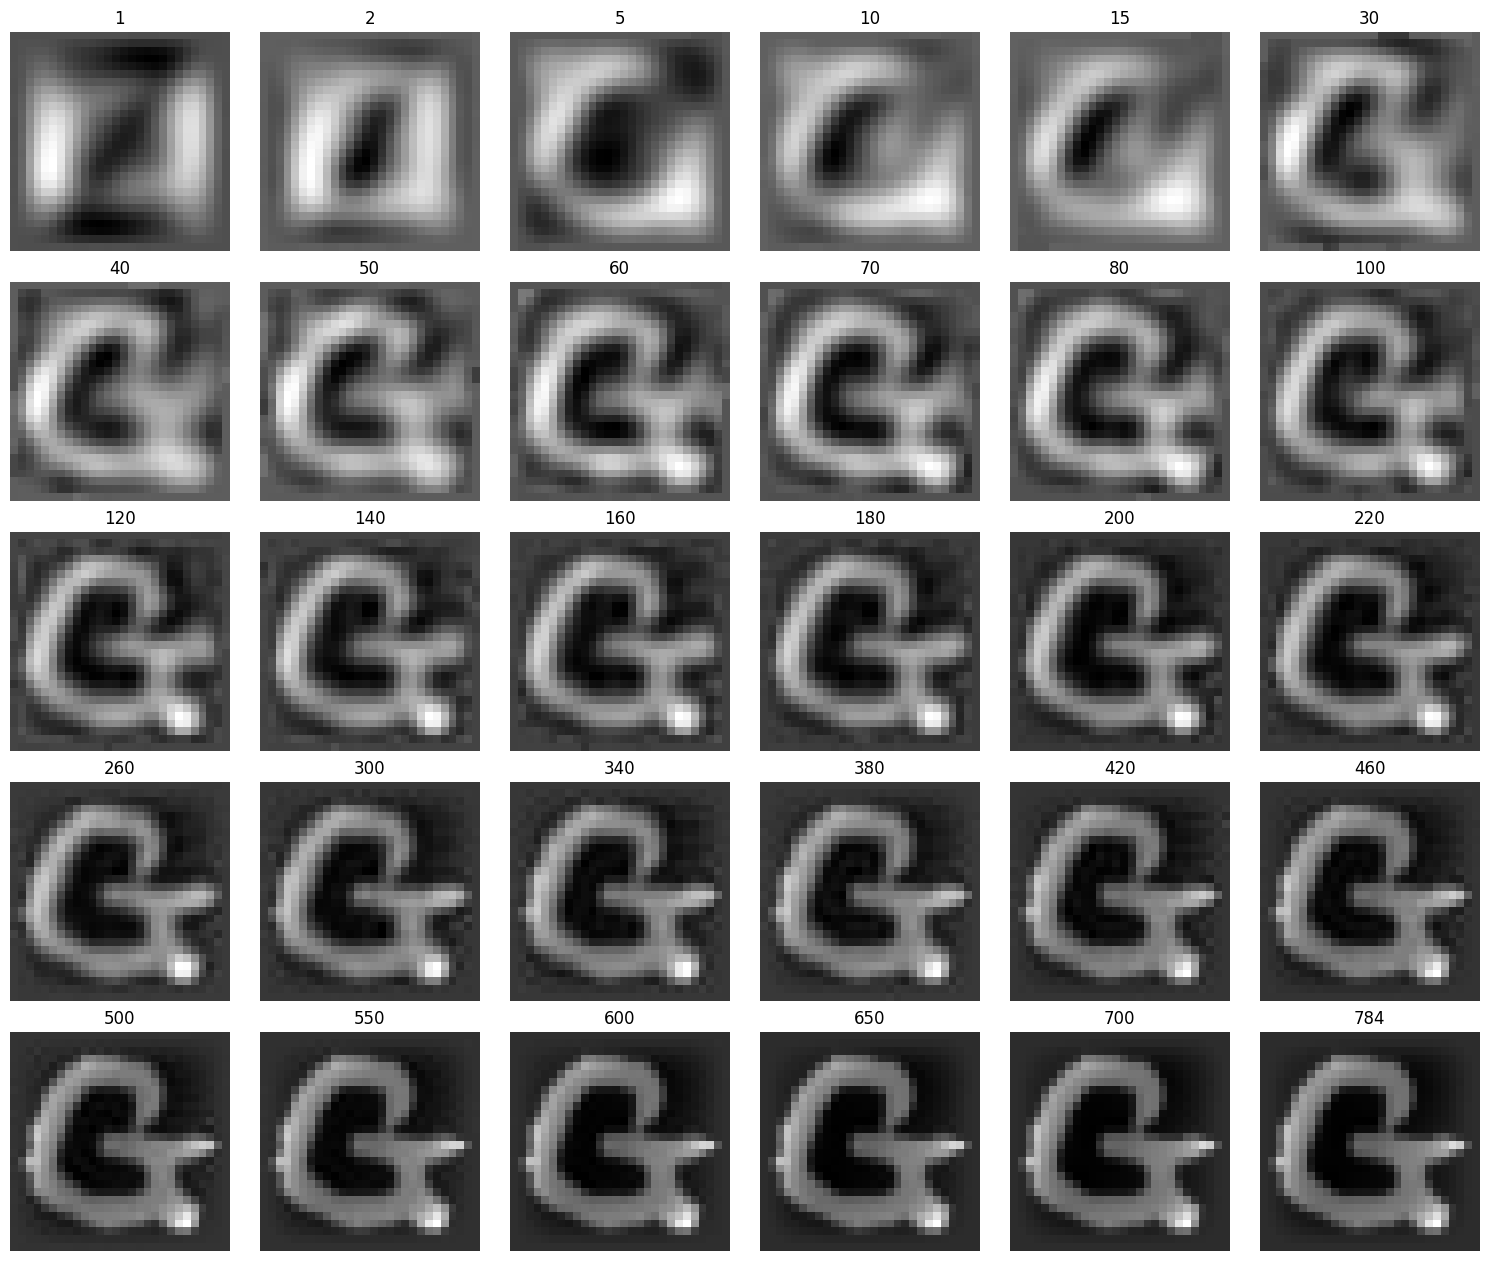

In [60]:
import matplotlib.pyplot as plt

sample=53
nrows, ncols = 5, 6
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15*nrows/ncols), constrained_layout=True)

dims = [1, 2, 5, 10, 15] + list(range(30,81,10)) + list(range(100, 221,20)) + list(range(260, 500, 40)) + list(range(500, 784,50))

def reconstruir(dim,c):
  reduced_X = X_train_em[sample,:] @ VT_em.T[:, :dim]
  X_reconstructed = reduced_X @ VT_em[:dim, :]
  ax = axes.flat[c]
  ax.set_axis_off()
  ax.imshow(X_reconstructed.reshape(28,28), cmap=plt.cm.gray, interpolation="none")
  ax.set_title(f"{dim}")

for i,d in enumerate(dims):
  reconstruir(d,i)

reconstruir(784,29)


### Entrenamiento con Regresión Logística y Análisis Cuadrático Discriminante con datos estandarizados.

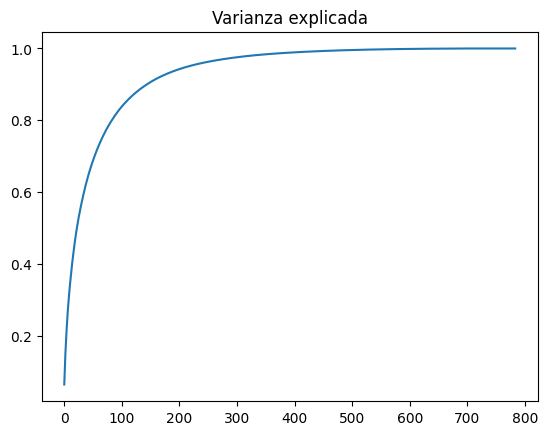

In [61]:
import matplotlib.pyplot as plt

plt.plot(np.cumsum(S_em**2)/np.sum(S_em**2))
plt.title("Varianza explicada")
plt.show()

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

accs_em_lr = []
red_dims =  [1, 5, 10, 20, 30, 50, 75, 100, 150, 200, 300, 400, 500, 700]
classifiers_em_lr = []
for dim in red_dims:
  reduced_X_train = X_train_em @ VT_em.T[:, :dim]
  reduced_X_test = X_test_em @ VT_em.T[:, :dim]
  clf = LogisticRegression(max_iter=1000).fit(reduced_X_train, y_train_em)
  classifiers_em_lr.append(clf)
  acc = accuracy_score(y_test_em, clf.predict(reduced_X_test))
  accs_em_lr.append(acc)
  print(f'La precisión para la dimensión {dim} es {acc:<1.3}')


La precisión para la dimensión 1 es 0.105
La precisión para la dimensión 5 es 0.31
La precisión para la dimensión 10 es 0.518
La precisión para la dimensión 20 es 0.628
La precisión para la dimensión 30 es 0.66
La precisión para la dimensión 50 es 0.689
La precisión para la dimensión 75 es 0.705
La precisión para la dimensión 100 es 0.713
La precisión para la dimensión 150 es 0.719
La precisión para la dimensión 200 es 0.721
La precisión para la dimensión 300 es 0.715
La precisión para la dimensión 400 es 0.71


C:\Users\JIVAGRI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


La precisión para la dimensión 500 es 0.705
La precisión para la dimensión 700 es 0.693


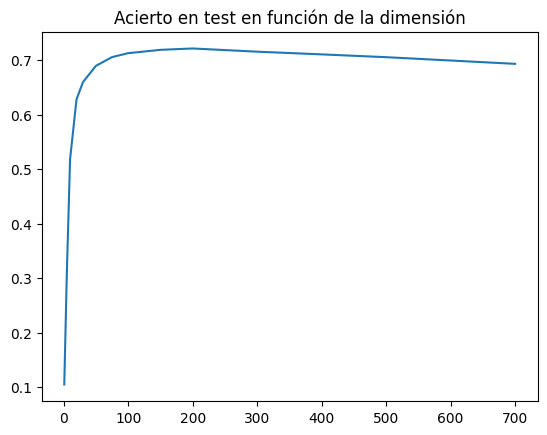

[0.10509615384615385, 0.3104326923076923, 0.5182692307692308, 0.6278846153846154, 0.6596153846153846, 0.6893269230769231, 0.7054326923076923, 0.7126442307692308, 0.71875, 0.72125, 0.7153846153846154, 0.7104326923076923, 0.7052884615384616, 0.693076923076923]


In [63]:
import matplotlib.pyplot as plt

plt.plot(red_dims, accs_em_lr)
plt.title("Acierto en test en función de la dimensión")
plt.show()
print(accs_em_lr)

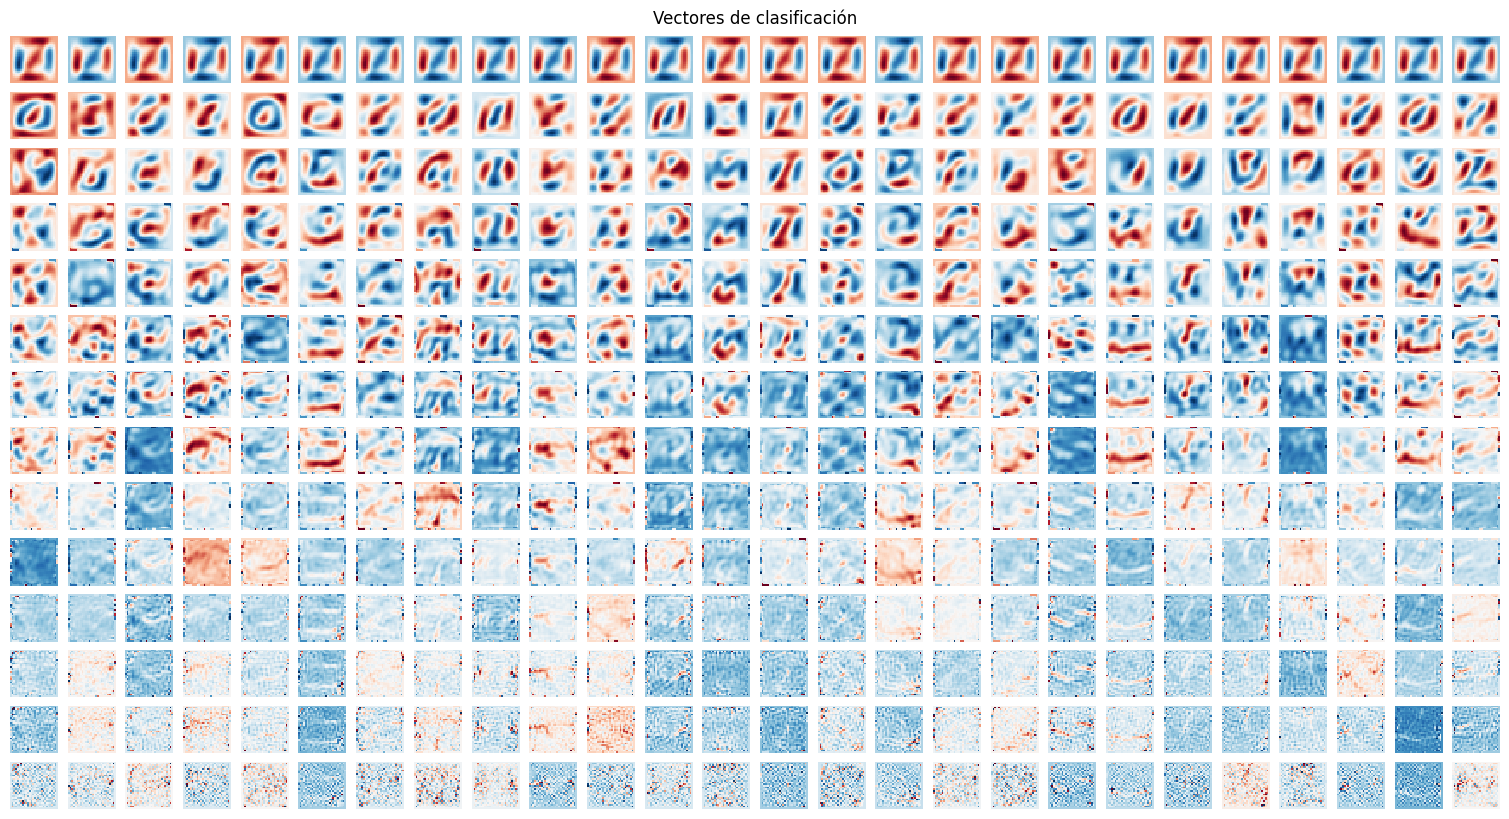

In [64]:
import matplotlib.pyplot as plt

coefs = [clf.coef_.copy() for clf in classifiers_em_lr]
nrows, ncols = len(coefs),coefs[0].shape[0]
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15*nrows/ncols), constrained_layout=True)

for i,coef in enumerate(coefs):
  scale = np.abs(coef).max()
  for sel_class in range(coef.shape[0]):
    coef_reconstructed = coef[sel_class] @ VT_em[:red_dims[i], :]
    ax = axes[i][sel_class]
    ax.set_axis_off()
    ax.imshow(
        coef_reconstructed.reshape(28, 28),
        interpolation="nearest",
        cmap=plt.cm.RdBu,

    )
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_xlabel("Class %i" % sel_class)
plt.suptitle("Vectores de clasificación")
plt.show()

In [65]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
import numpy as np

accs_em_per = []

red_dims =  [1, 5, 10, 20, 30, 50, 75, 100, 150, 200, 300, 400, 500, 700]
classifiers_em_per = []
for dim in red_dims:
  reduced_X_train = X_train_em @ VT_em.T[:, :dim]
  reduced_X_test = X_test_em @ VT_em.T[:, :dim]
  clf = Perceptron().fit(reduced_X_train, y_train_em)
  classifiers_em_per.append(clf)

  acc = accuracy_score(y_test_em, clf.predict(reduced_X_test))
  accs_em_per.append(acc)
  print(f'La precisión para la dimensión {dim} es {acc:<1.3}')

La precisión para la dimensión 1 es 0.0502
La precisión para la dimensión 5 es 0.152
La precisión para la dimensión 10 es 0.29
La precisión para la dimensión 20 es 0.426
La precisión para la dimensión 30 es 0.489
La precisión para la dimensión 50 es 0.5
La precisión para la dimensión 75 es 0.548
La precisión para la dimensión 100 es 0.555
La precisión para la dimensión 150 es 0.538
La precisión para la dimensión 200 es 0.562
La precisión para la dimensión 300 es 0.538
La precisión para la dimensión 400 es 0.565
La precisión para la dimensión 500 es 0.55
La precisión para la dimensión 700 es 0.543


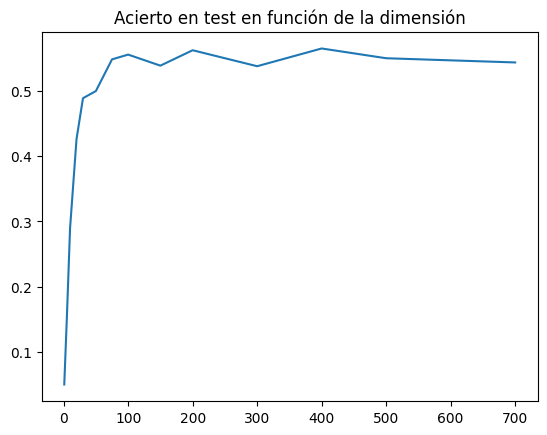

[0.05024038461538462, 0.15216346153846153, 0.2898076923076923, 0.4260096153846154, 0.4886057692307692, 0.49956730769230767, 0.5480769230769231, 0.5553846153846154, 0.5384615384615384, 0.5620673076923077, 0.5375961538461539, 0.5647596153846154, 0.5498076923076923, 0.5433653846153846]


In [66]:
import matplotlib.pyplot as plt

plt.plot(red_dims,accs_em_per)
plt.title("Acierto en test en función de la dimensión")
plt.show()
print(accs_em_per)

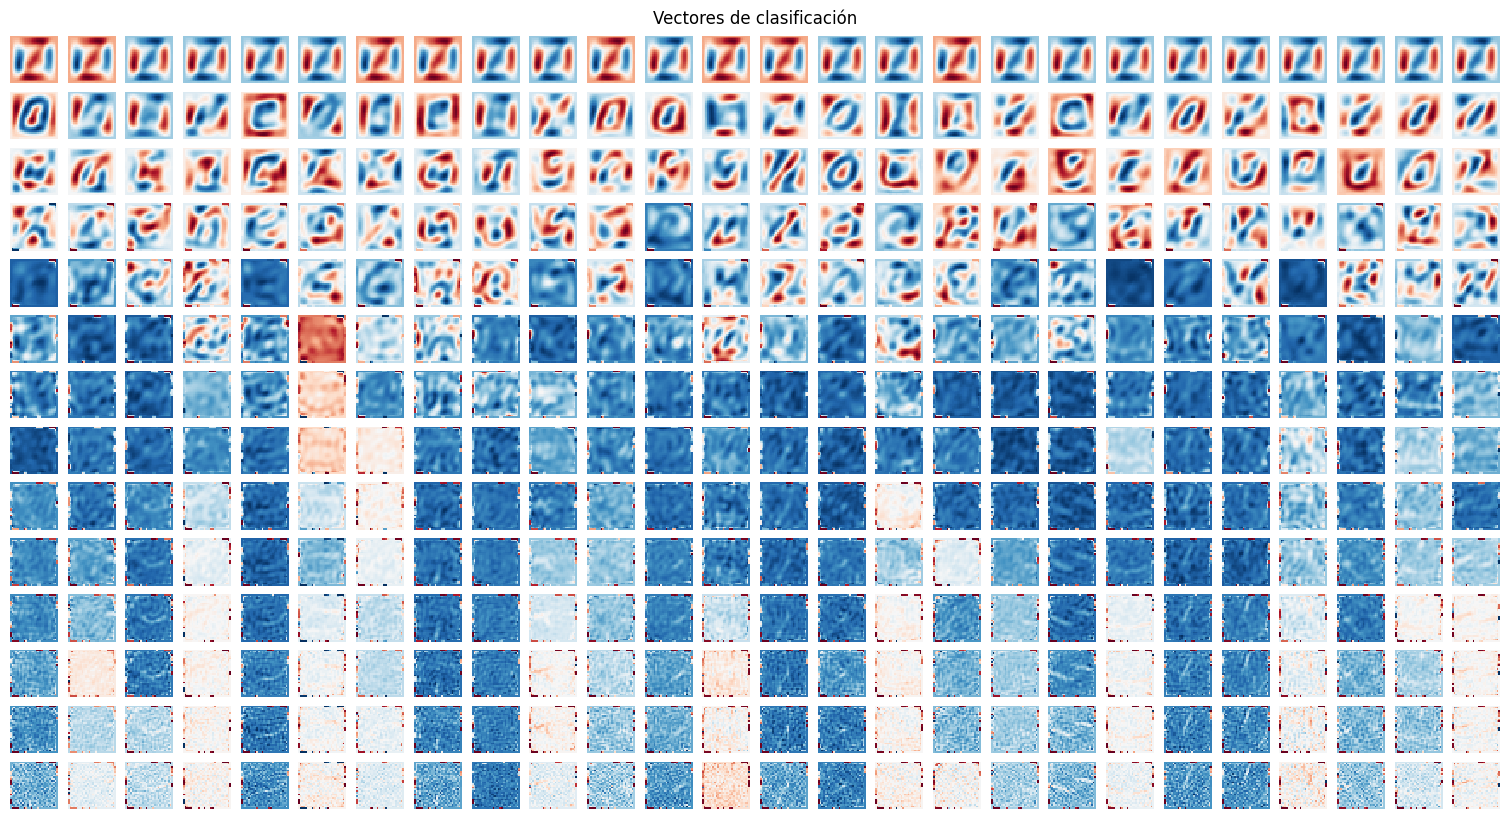

In [67]:
import matplotlib.pyplot as plt

coefs = [clf.coef_.copy() for clf in classifiers_em_per]
nrows, ncols = len(coefs),coefs[0].shape[0]
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15*nrows/ncols), constrained_layout=True)

for i,coef in enumerate(coefs):
  scale = np.abs(coef).max()
  for sel_class in range(coef.shape[0]):
    coef_reconstructed = coef[sel_class] @ VT_em[:red_dims[i], :]
    ax = axes[i][sel_class]
    ax.set_axis_off()
    ax.imshow(
        coef_reconstructed.reshape(28, 28),
        interpolation="nearest",
        cmap=plt.cm.RdBu,

    )
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_xlabel("Class %i" % sel_class)
plt.suptitle("Vectores de clasificación")
plt.show()

# Dataset 3: Fashion MNIST

In [68]:
from sklearn.datasets import fetch_openml
import numpy as np

fashion_mnist = fetch_openml(data_id=40996)

C:\Users\JIVAGRI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [69]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Barajar los datos
fashion_mnist.data, fashion_mnist.target = shuffle(fashion_mnist.data, fashion_mnist.target, random_state=42)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_fm, X_test_fm, y_train_fm, y_test_fm = train_test_split(fashion_mnist.data, fashion_mnist.target, test_size=0.10, random_state=42)

# Normalización de los datos
scaler = StandardScaler()
X_train_fm = scaler.fit_transform(X_train_fm)
X_test_fm = scaler.transform(X_test_fm)

In [70]:
U_fm, S_fm, VT_fm = np.linalg.svd(X_train_fm, full_matrices=False)

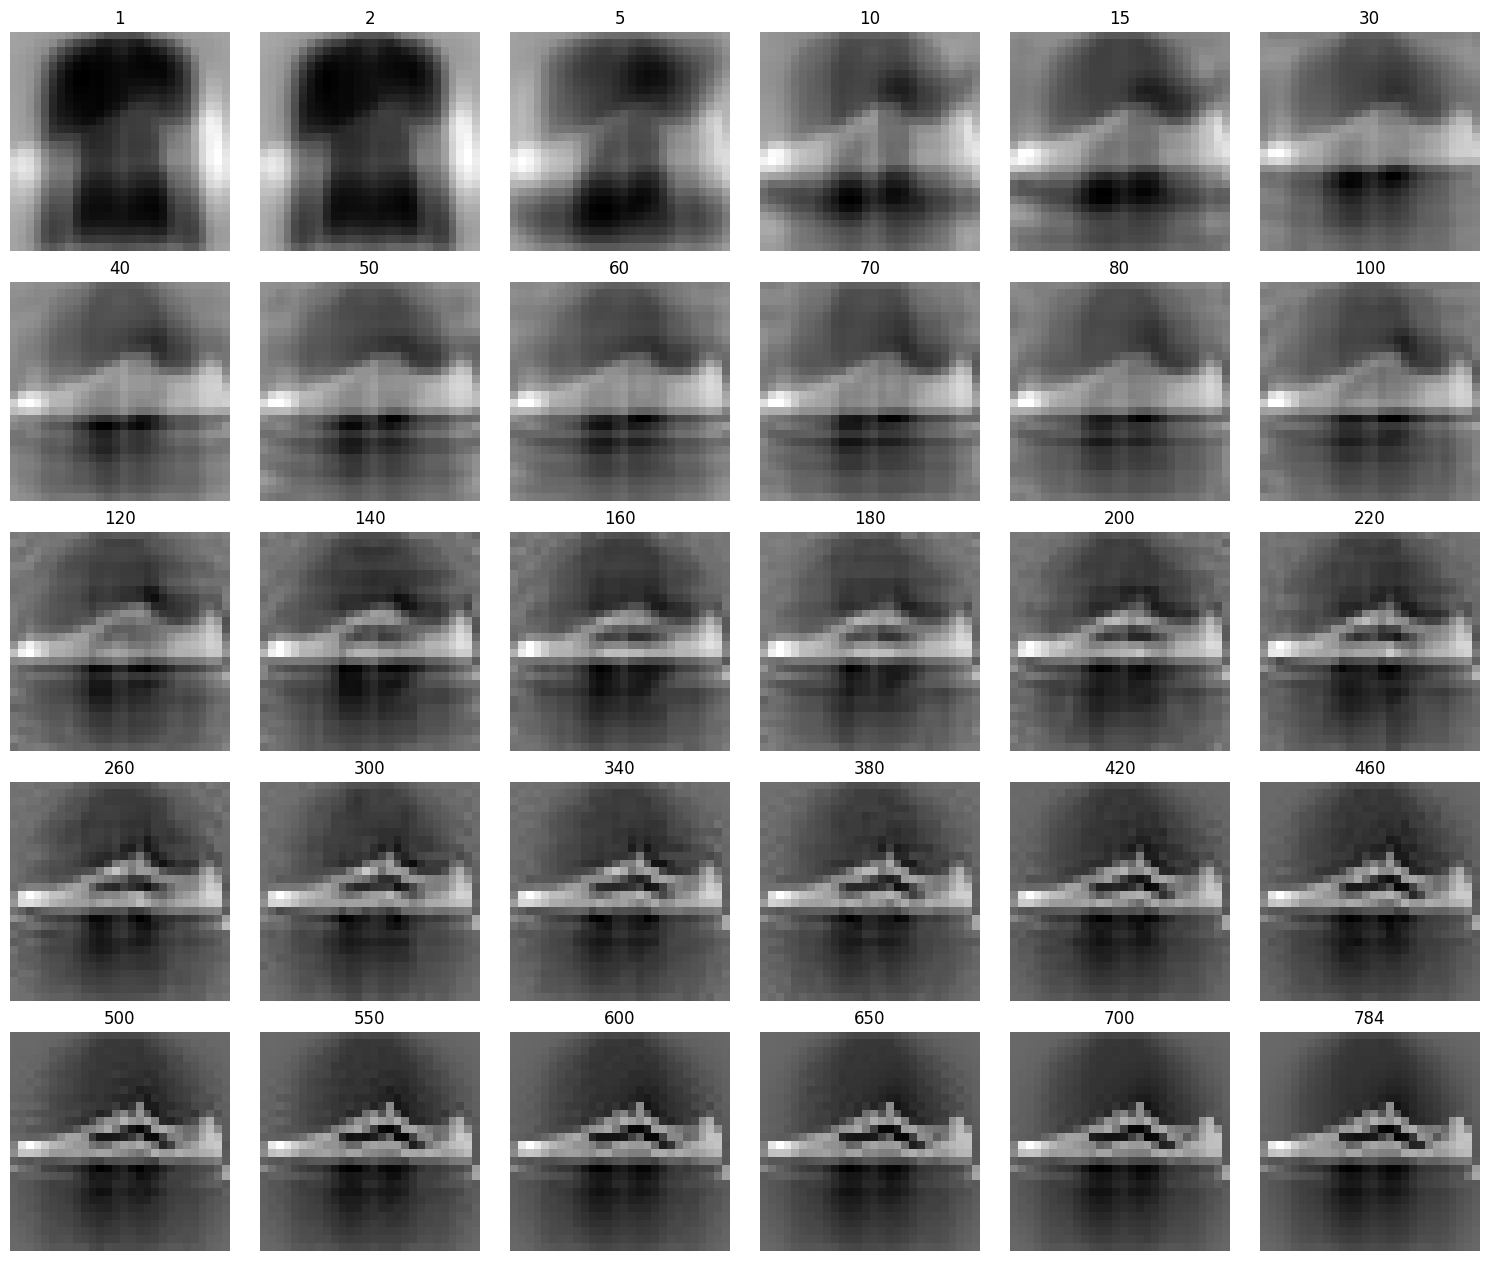

In [ ]:
import matplotlib.pyplot as plt

sample=15
nrows, ncols = 5, 6
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15*nrows/ncols), constrained_layout=True)

dims = [1, 2, 5, 10, 15] + list(range(30,81,10)) + list(range(100, 221,20)) + list(range(260, 500, 40)) + list(range(500, 784,50))

def reconstruir(dim,c):
  reduced_X = X_train_fm[sample,:] @ VT_fm.T[:, :dim]
  X_reconstructed = reduced_X @ VT_fm[:dim, :]
  ax = axes.flat[c]
  ax.set_axis_off()
  ax.imshow(X_reconstructed.reshape(28,28), cmap=plt.cm.gray, interpolation="none")
  ax.set_title(f"{dim}")

for i,d in enumerate(dims):
    reconstruir(d,i)

reconstruir(784,29)

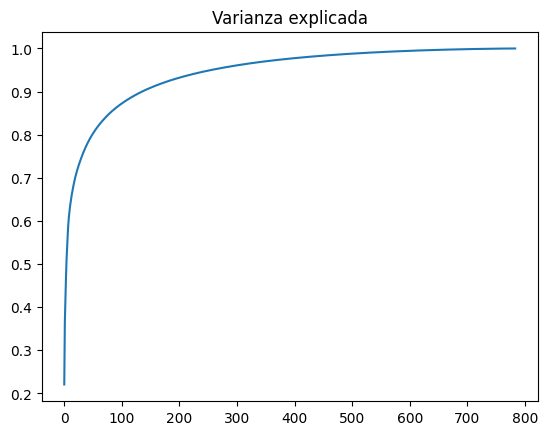

In [71]:
import matplotlib.pyplot as plt

plt.plot(np.cumsum(S_fm**2)/np.sum(S_fm**2))
plt.title("Varianza explicada")
plt.show()

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

accs = []

red_dims =  [1, 5, 10, 20, 30, 50, 75, 100, 150, 200, 300, 400, 500, 700]
classifiers_fm_lr = []
for dim in red_dims:
  reduced_X_train = X_train_fm @ VT_fm.T[:, :dim]
  reduced_X_test = X_test_fm @ VT_fm.T[:, :dim]
  clf = LogisticRegression(max_iter=1000).fit(reduced_X_train, y_train_fm)
  classifiers_fm_lr.append(clf)
  acc = accuracy_score(y_test_fm, clf.predict(reduced_X_test))
  accs.append(acc)
  print(f'La precisión para la dimensión {dim} es {acc:<1.3}')

La precisión para la dimensión 1 es 0.268
La precisión para la dimensión 5 es 0.693


C:\Users\JIVAGRI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


La precisión para la dimensión 10 es 0.753


C:\Users\JIVAGRI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


La precisión para la dimensión 20 es 0.803


C:\Users\JIVAGRI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


La precisión para la dimensión 30 es 0.818


C:\Users\JIVAGRI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


La precisión para la dimensión 50 es 0.833


C:\Users\JIVAGRI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


La precisión para la dimensión 75 es 0.839


C:\Users\JIVAGRI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


La precisión para la dimensión 100 es 0.85


C:\Users\JIVAGRI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


La precisión para la dimensión 150 es 0.855


C:\Users\JIVAGRI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


La precisión para la dimensión 200 es 0.854


C:\Users\JIVAGRI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


La precisión para la dimensión 300 es 0.857


C:\Users\JIVAGRI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


La precisión para la dimensión 400 es 0.856


C:\Users\JIVAGRI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


La precisión para la dimensión 500 es 0.854
La precisión para la dimensión 700 es 0.85


C:\Users\JIVAGRI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


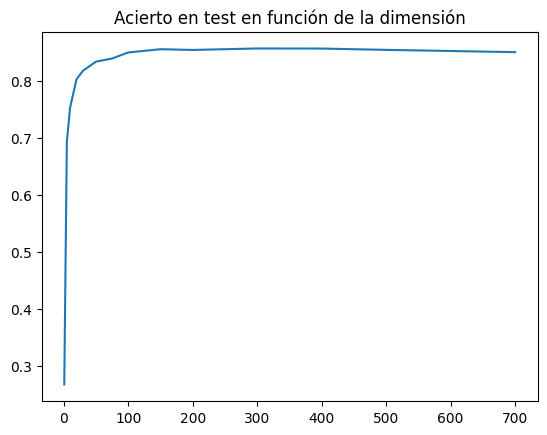

[0.2681428571428571, 0.6931428571428572, 0.7528571428571429, 0.8027142857142857, 0.8175714285714286, 0.8334285714285714, 0.839, 0.8495714285714285, 0.8552857142857143, 0.854, 0.8565714285714285, 0.8564285714285714, 0.8541428571428571, 0.8501428571428571]


In [73]:
import matplotlib.pyplot as plt

plt.plot(red_dims,accs)
plt.title("Acierto en test en función de la dimensión")
plt.show()
print(accs)

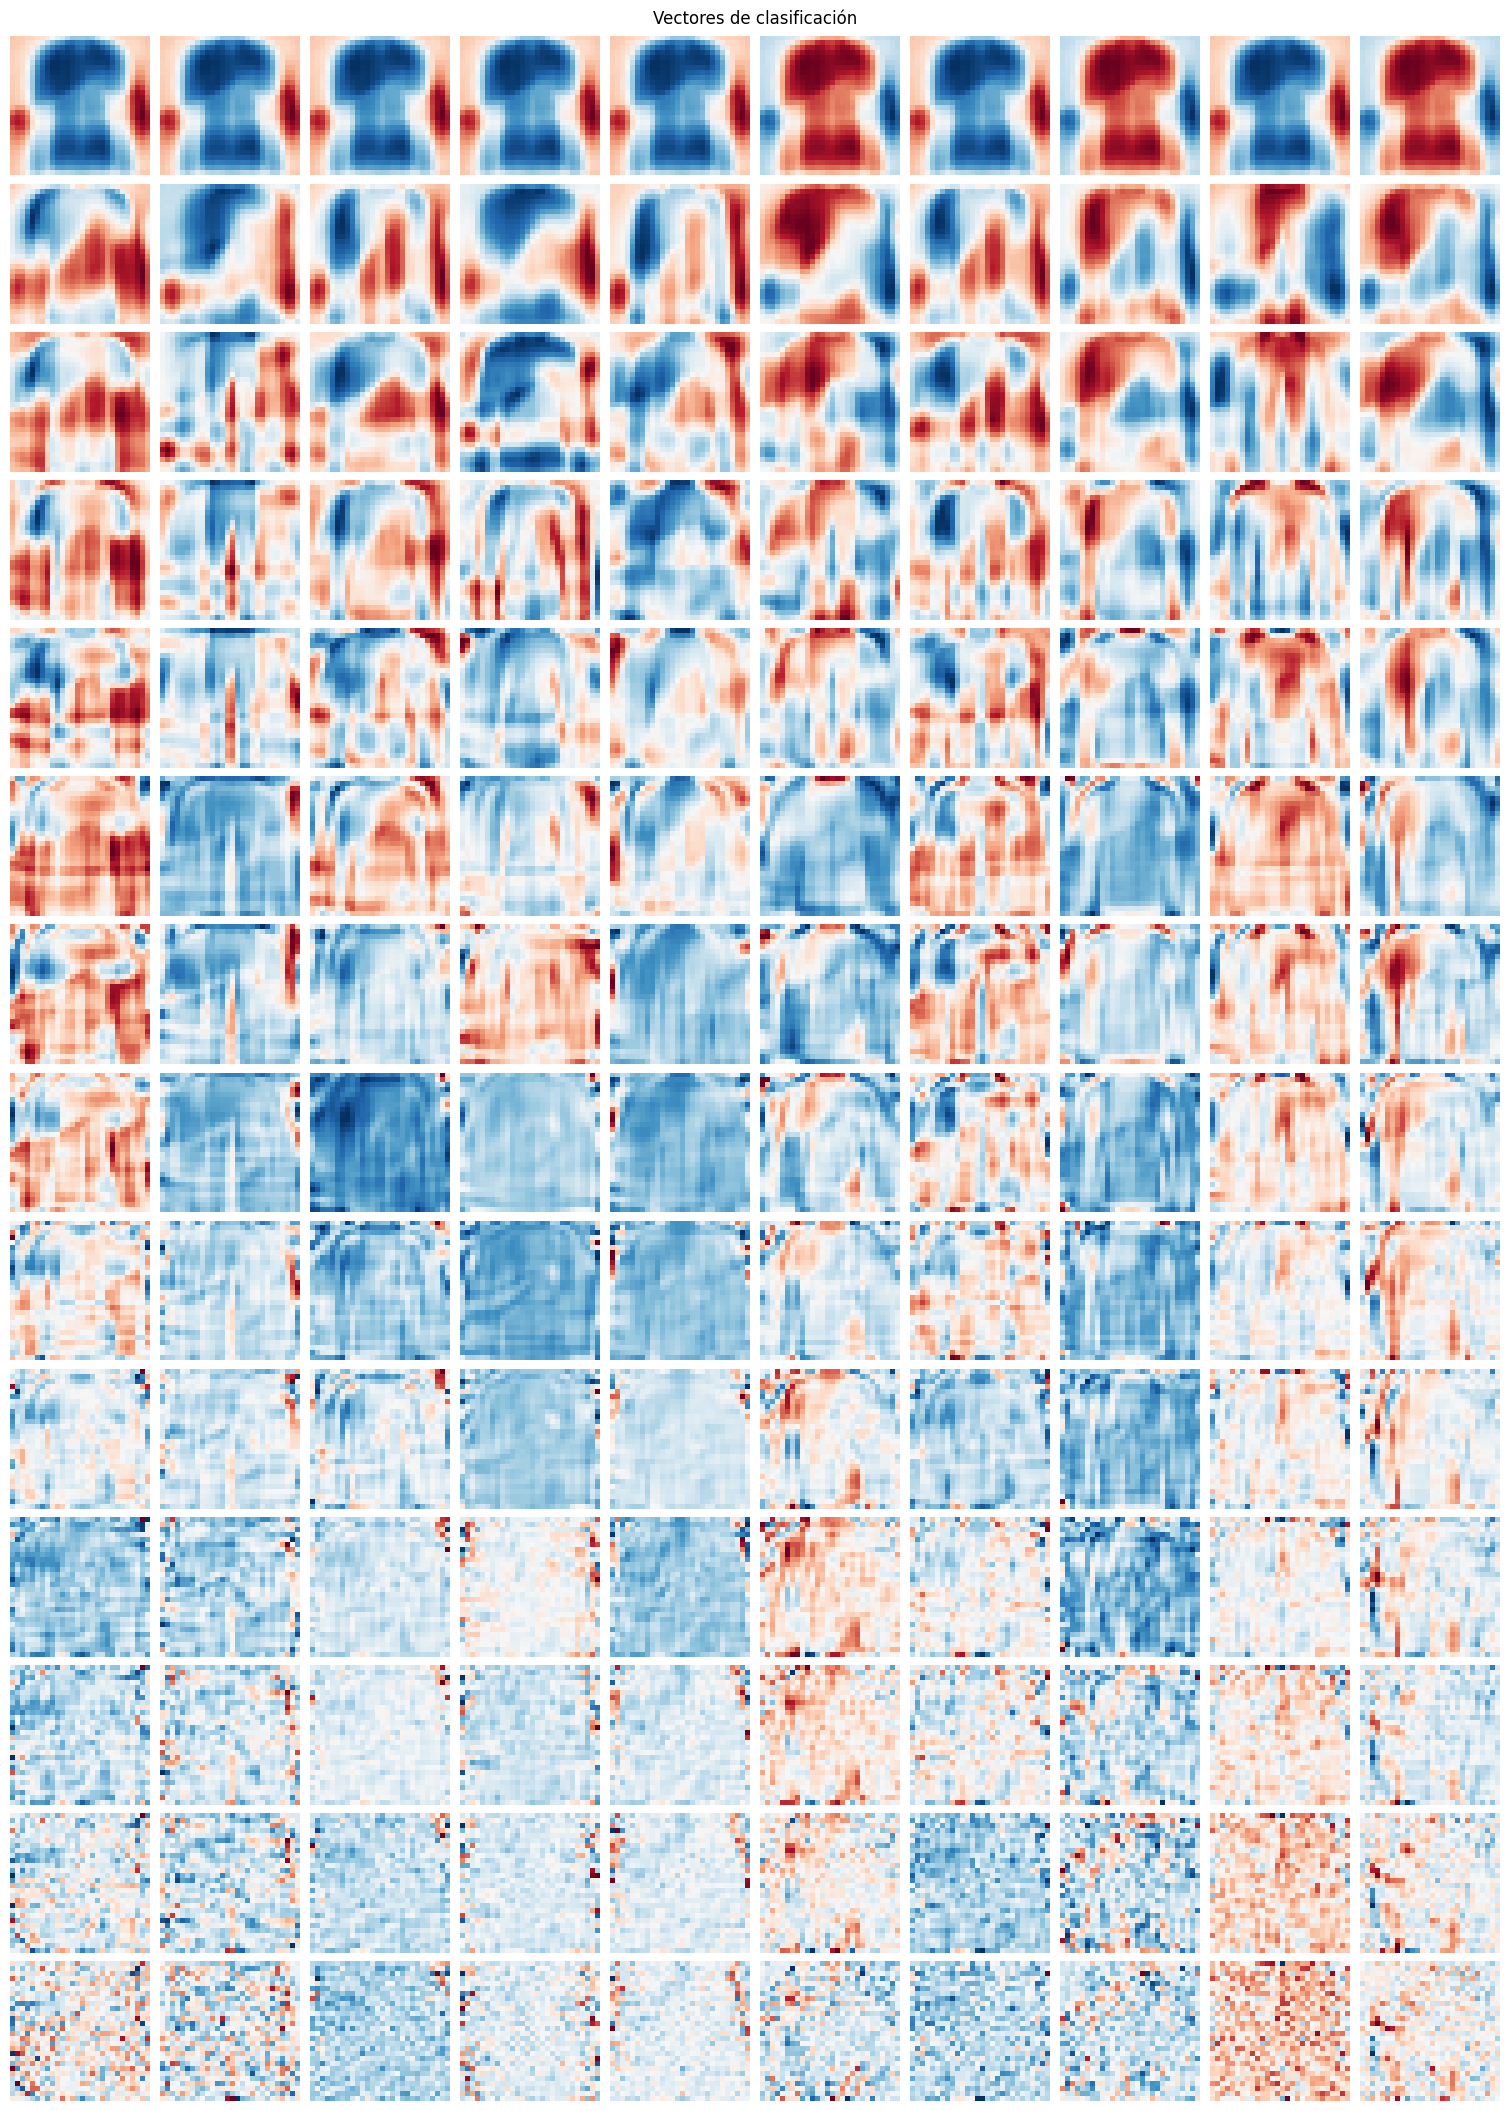

In [74]:
import matplotlib.pyplot as plt

coefs = [clf.coef_.copy() for clf in classifiers_fm_lr]
nrows, ncols = len(coefs),coefs[0].shape[0]
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15*nrows/ncols), constrained_layout=True)

for i,coef in enumerate(coefs):
  scale = np.abs(coef).max()
  for sel_class in range(coef.shape[0]):
    coef_reconstructed = coef[sel_class] @ VT_fm[:red_dims[i], :]
    ax = axes[i][sel_class]
    ax.set_axis_off()
    ax.imshow(
        coef_reconstructed.reshape(28, 28),
        interpolation="nearest",
        cmap=plt.cm.RdBu,

    )
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_xlabel("Class %i" % sel_class)
plt.suptitle("Vectores de clasificación")
plt.show()

In [75]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
import numpy as np

accs_fm_per = []

red_dims = [1, 5, 10, 20, 30, 50, 75, 100, 150, 200, 300, 400, 500, 700]
classifiers_fm_per = []
for dim in red_dims:
  reduced_X_train = X_train_fm @ VT_fm.T[:, :dim]
  reduced_X_test = X_test_fm @ VT_fm.T[:, :dim]
  clf = Perceptron().fit(reduced_X_train, y_train_fm)
  classifiers_fm_per.append(clf)

  acc = accuracy_score(y_test_fm, clf.predict(reduced_X_test))
  accs_fm_per.append(acc)
  print(f'La precisión para la dimensión {dim} es {acc:<1.3}')


La precisión para la dimensión 1 es 0.158
La precisión para la dimensión 5 es 0.525
La precisión para la dimensión 10 es 0.669
La precisión para la dimensión 20 es 0.699
La precisión para la dimensión 30 es 0.734
La precisión para la dimensión 50 es 0.754
La precisión para la dimensión 75 es 0.777
La precisión para la dimensión 100 es 0.77
La precisión para la dimensión 150 es 0.778
La precisión para la dimensión 200 es 0.778
La precisión para la dimensión 300 es 0.798
La precisión para la dimensión 400 es 0.792
La precisión para la dimensión 500 es 0.799
La precisión para la dimensión 700 es 0.818


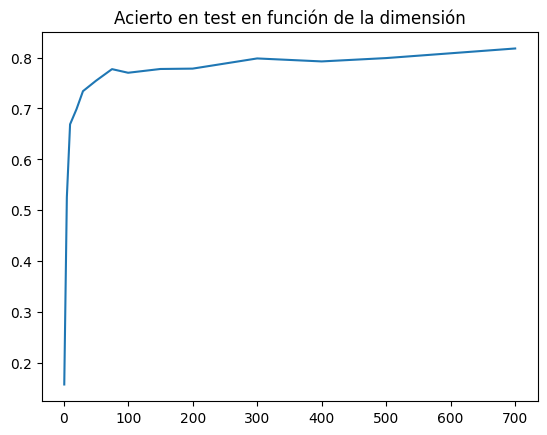

[0.15771428571428572, 0.5254285714285715, 0.6688571428571428, 0.6987142857142857, 0.734, 0.7542857142857143, 0.7772857142857142, 0.7701428571428571, 0.7775714285714286, 0.7782857142857142, 0.7982857142857143, 0.7924285714285715, 0.799, 0.8178571428571428]


In [76]:
import matplotlib.pyplot as plt

plt.plot(red_dims,accs_fm_per)
plt.title("Acierto en test en función de la dimensión")
plt.show()
print(accs_fm_per)

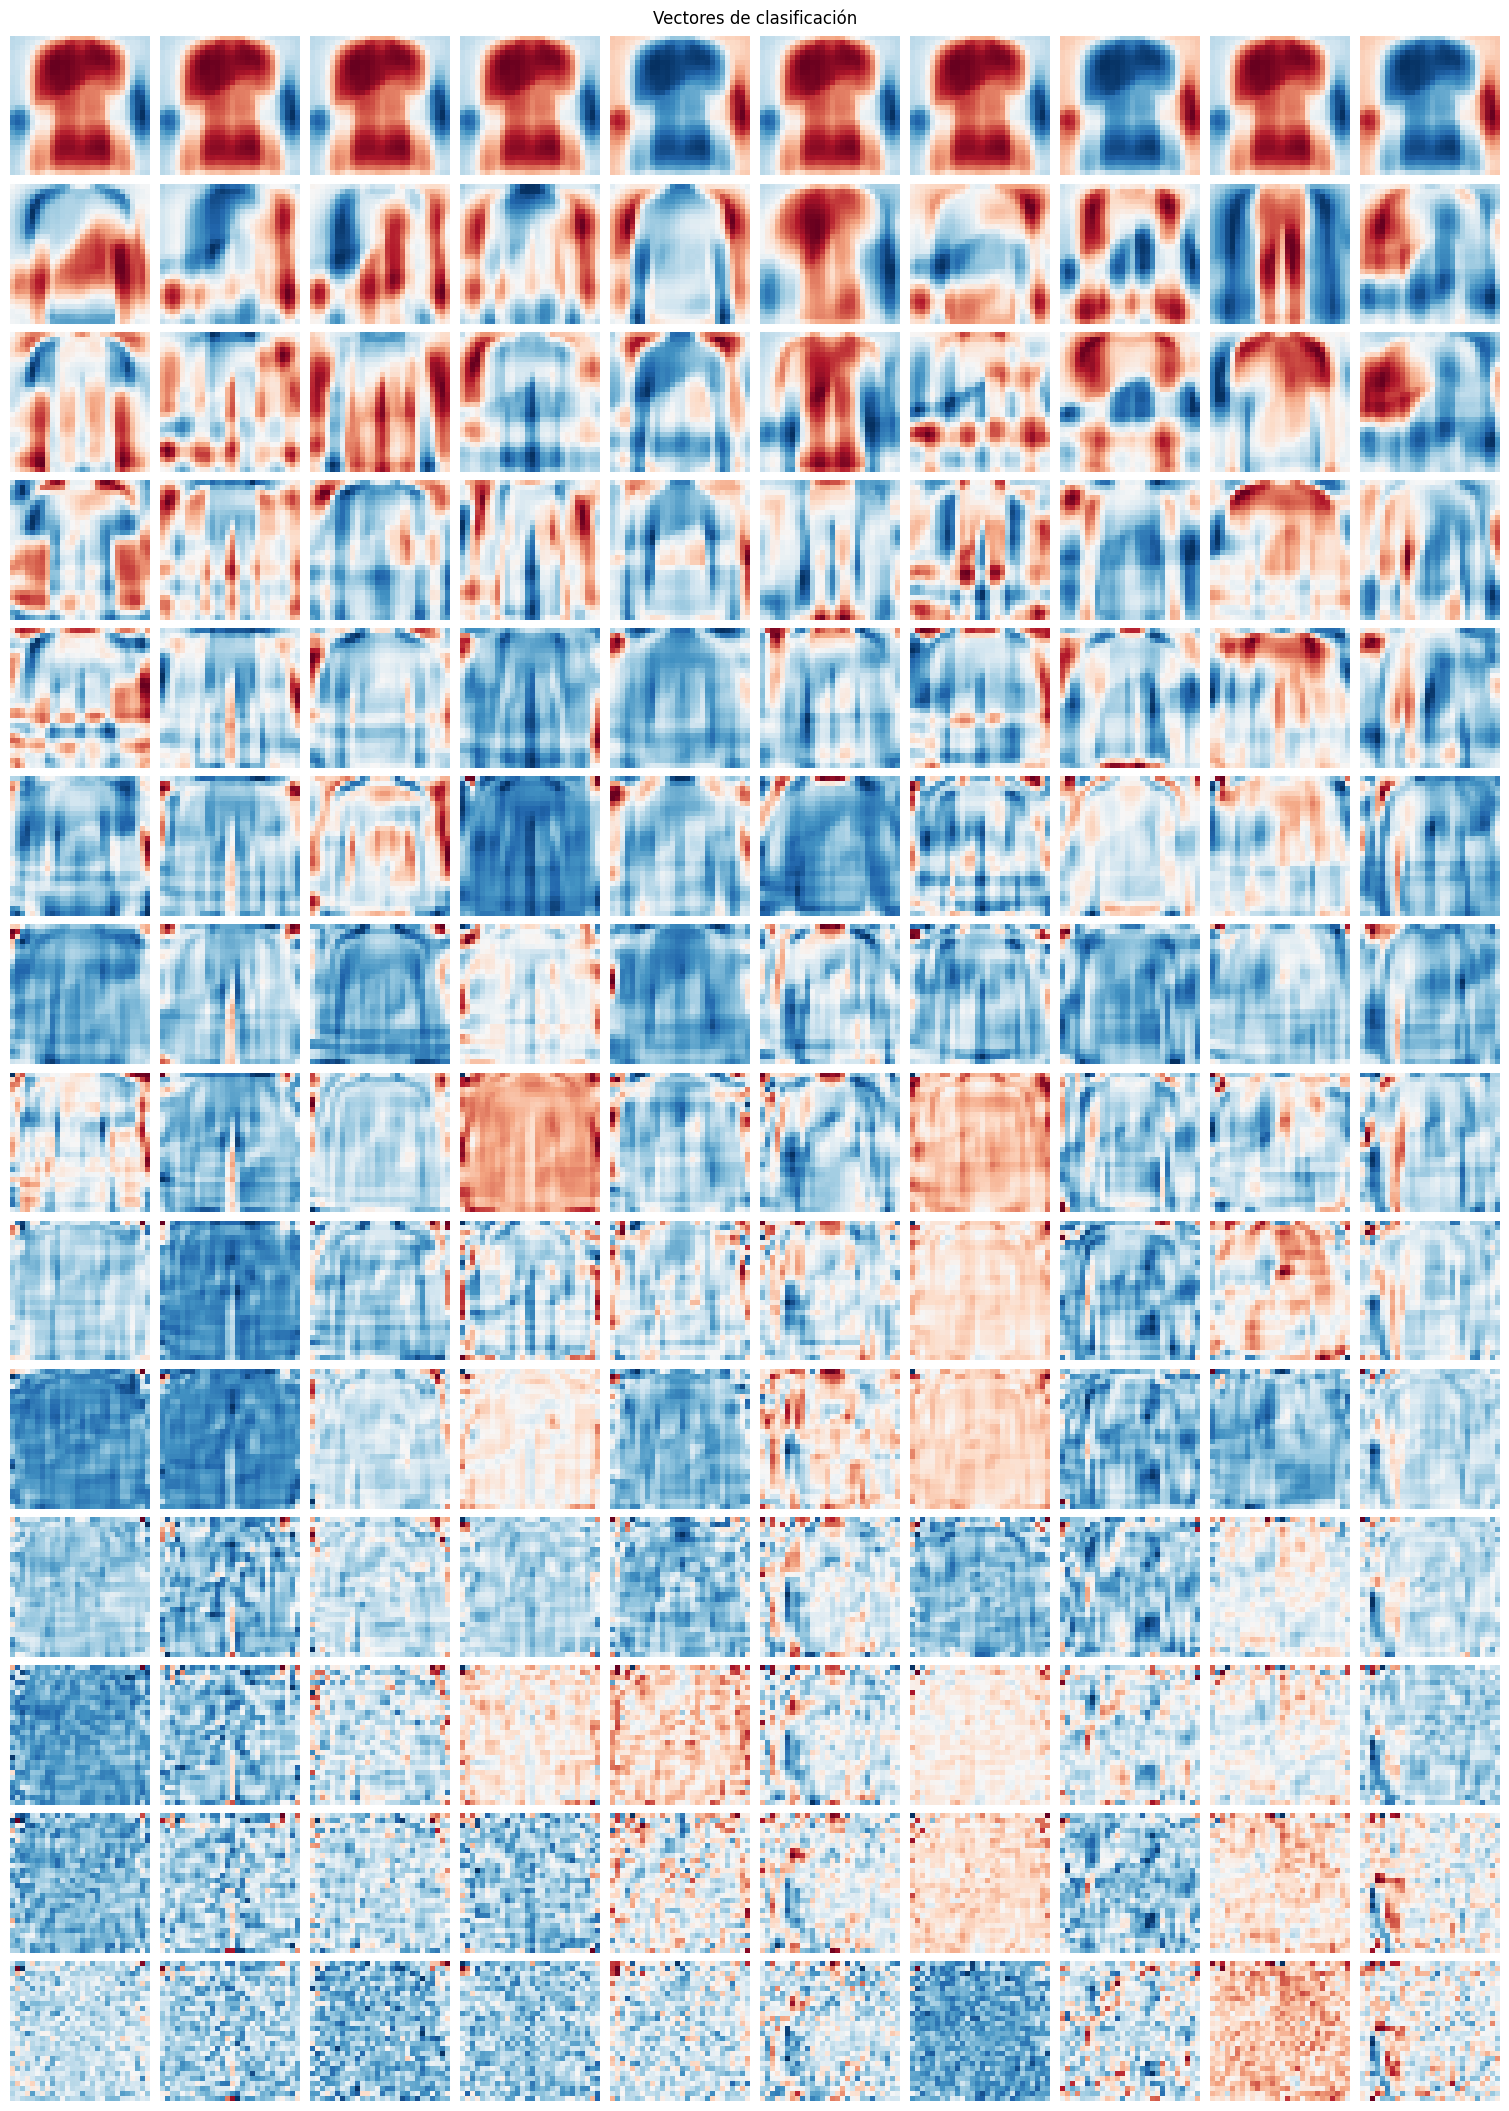

In [77]:
import matplotlib.pyplot as plt

coefs = [clf.coef_.copy() for clf in classifiers_fm_per]
nrows, ncols = len(coefs),coefs[0].shape[0]
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15*nrows/ncols), constrained_layout=True)

for i,coef in enumerate(coefs):
  scale = np.abs(coef).max()
  for sel_class in range(coef.shape[0]):
    coef_reconstructed = coef[sel_class] @ VT_fm[:red_dims[i], :]
    ax = axes[i][sel_class]
    ax.set_axis_off()
    ax.imshow(
        coef_reconstructed.reshape(28, 28),
        interpolation="nearest",
        cmap=plt.cm.RdBu,

    )
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_xlabel("Class %i" % sel_class)
plt.suptitle("Vectores de clasificación")
plt.show()